In [1]:
# import things
%matplotlib notebook
import tensorflow as tf
from tensorflow import keras
from mpl_toolkits import mplot3d
import numpy as np
from numpy import matlib
from scipy import signal
from scipy.spatial import distance
from scipy.stats import norm
from scipy.stats import percentileofscore
import scipy.linalg as linalg

import random
import matplotlib.pyplot as plt
import os

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize

from dPCA import dPCA

<IPython.core.display.Javascript object>


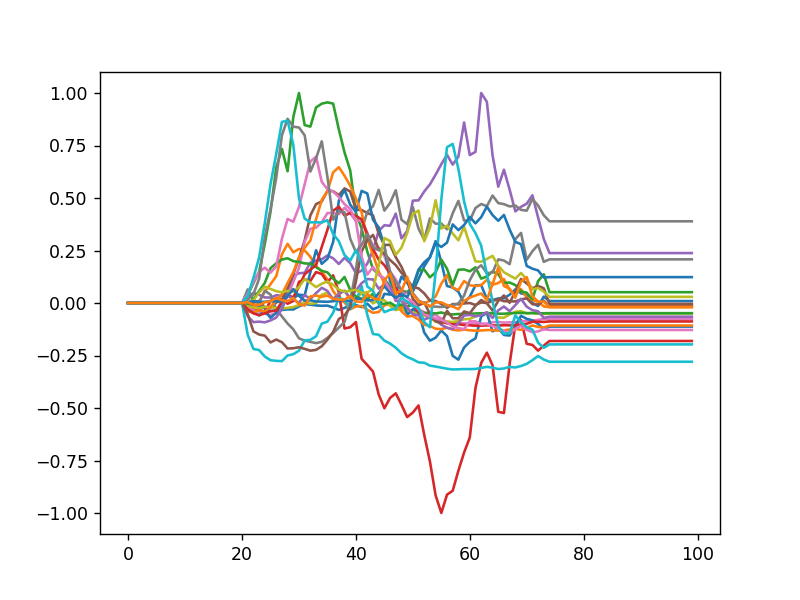

In [2]:
# import desired emg or velocity trajectories
predict_emg = 1
do_emg_norm = 1
go_cue_idx = 20
hold_idx = 10

%run ./get_stim_dynamics_inputs.ipynb
x_train,y_train,x_test,y_test,degs = get_input_data(predict_emg,do_emg_norm,go_cue_idx,hold_idx)
plt.plot(y_train[1,:,:]);

# params
%run Param_classes.ipynb
args = InitialParams()   
stim_params = StimParams()

# more verbose params
if(predict_emg):
    l2_weight = 1e-3
    activation_weight = 1e-7
    args.lambda_l = 1e-6
    dropout_rate = 0.5
    conn_prob = 1
    args.latent_shape = [30,30]
    lr = 0.0001
    n_epochs = 3000
else:
    l2_weight = 1e-3
    activation_weight = 1e-3
    args.lambda_l = 1e-5
    dropout_rate = 0.5
    conn_prob = 1
    args.latent_shape = [20,20]
    lr = 0.0001
    n_epochs = 2000    

In [3]:
%run ./RNN_model.ipynb

num_units = args.latent_shape[0]*args.latent_shape[1]
temp_lat = lateral_effect(args)   

input_layer = keras.Input(shape=[None,x_train.shape[-1]],batch_size=x_train.shape[0])
cell = SimpleRNN_pos_loss(num_units,activation="tanh",conn_prob = conn_prob,
                              kernel_regularizer=keras.regularizers.l2(l2_weight),activation_weight=activation_weight)
RNN_layer, state_h = keras.layers.RNN(cell,return_sequences=True,return_state=True,dynamic=True)(input_layer)                                   
dropout_layer = keras.layers.Dropout(dropout_rate)(RNN_layer)
output_layer = keras.layers.TimeDistributed(keras.layers.Dense(y_test.shape[2]))(dropout_layer)

model = tf.keras.Model(inputs=input_layer,outputs=output_layer)
stim_params.is_stim=False
optimizer = keras.optimizers.Adam(learning_rate=lr)


early_stopping_cb = keras.callbacks.EarlyStopping(patience=n_epochs/5,
                                                  restore_best_weights=True,monitor="loss")

model.compile(loss="mse",optimizer=optimizer,metrics=[keras.metrics.MeanSquaredError()])

In [4]:
history=model.fit(x_train,y_train,epochs=n_epochs,verbose=True,callbacks=[early_stopping_cb])
layer_outputs = [layer.output for layer in model.layers]
activation_model = keras.models.Model(inputs=model.input,outputs=layer_outputs)

Train on 4 samples
Epoch 1/3000
4/4 [==============================] - 1s 164ms/sample - loss: 0.4707 - mean_squared_error: 0.4667
Epoch 2/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.3205 - mean_squared_error: 0.3165
Epoch 3/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.2670 - mean_squared_error: 0.2630
Epoch 4/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.2455 - mean_squared_error: 0.2415
Epoch 5/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.2358 - mean_squared_error: 0.2318
Epoch 6/3000
4/4 [==============================] - 0s 109ms/sample - loss: 0.2323 - mean_squared_error: 0.2284
Epoch 7/3000
4/4 [==============================] - 0s 97ms/sample - loss: 0.2254 - mean_squared_error: 0.2214
Epoch 8/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.2212 - mean_squared_error: 0.2172
Epoch 9/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.2114 - mean_sq

Epoch 74/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.1270 - mean_squared_error: 0.1232
Epoch 75/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.1233 - mean_squared_error: 0.1195
Epoch 76/3000
4/4 [==============================] - 0s 97ms/sample - loss: 0.1256 - mean_squared_error: 0.1218
Epoch 77/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.1208 - mean_squared_error: 0.1169
Epoch 78/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.1254 - mean_squared_error: 0.1215
Epoch 79/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.1238 - mean_squared_error: 0.1200
Epoch 80/3000
4/4 [==============================] - 0s 97ms/sample - loss: 0.1215 - mean_squared_error: 0.1177
Epoch 81/3000
4/4 [==============================] - 0s 95ms/sample - loss: 0.1245 - mean_squared_error: 0.1207
Epoch 82/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.1244 - mean_squared_erro

Epoch 147/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.1053 - mean_squared_error: 0.1016
Epoch 148/3000
4/4 [==============================] - 0s 110ms/sample - loss: 0.1029 - mean_squared_error: 0.0991
Epoch 149/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.1014 - mean_squared_error: 0.0976
Epoch 150/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.1065 - mean_squared_error: 0.1027
Epoch 151/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.1056 - mean_squared_error: 0.1018
Epoch 152/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.1010 - mean_squared_error: 0.0972
Epoch 153/3000
4/4 [==============================] - 0s 96ms/sample - loss: 0.1000 - mean_squared_error: 0.0962
Epoch 154/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.1019 - mean_squared_error: 0.0981
Epoch 155/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.1035 - mean_sq

Epoch 220/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0873 - mean_squared_error: 0.0835
Epoch 221/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0901 - mean_squared_error: 0.0864
Epoch 222/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0874 - mean_squared_error: 0.0836
Epoch 223/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0891 - mean_squared_error: 0.0854
Epoch 224/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0896 - mean_squared_error: 0.0859
Epoch 225/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0925 - mean_squared_error: 0.0888
Epoch 226/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0868 - mean_squared_error: 0.0831
Epoch 227/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0883 - mean_squared_error: 0.0845
Epoch 228/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0874 - mean_sq

Epoch 293/3000
4/4 [==============================] - 0s 96ms/sample - loss: 0.0786 - mean_squared_error: 0.0749
Epoch 294/3000
4/4 [==============================] - 0s 96ms/sample - loss: 0.0789 - mean_squared_error: 0.0752
Epoch 295/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0788 - mean_squared_error: 0.0751
Epoch 296/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.0801 - mean_squared_error: 0.0764
Epoch 297/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.0809 - mean_squared_error: 0.0772
Epoch 298/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0802 - mean_squared_error: 0.0765
Epoch 299/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0782 - mean_squared_error: 0.0746
Epoch 300/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0776 - mean_squared_error: 0.0739
Epoch 301/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0772 - mean_sq

Epoch 366/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.0783 - mean_squared_error: 0.0746
Epoch 367/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0729 - mean_squared_error: 0.0693
Epoch 368/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0706 - mean_squared_error: 0.0670
Epoch 369/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0739 - mean_squared_error: 0.0702
Epoch 370/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.0726 - mean_squared_error: 0.0690
Epoch 371/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0723 - mean_squared_error: 0.0687
Epoch 372/3000
4/4 [==============================] - 0s 97ms/sample - loss: 0.0742 - mean_squared_error: 0.0706
Epoch 373/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0722 - mean_squared_error: 0.0686
Epoch 374/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0733 - mean_s

Epoch 439/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0679 - mean_squared_error: 0.0643
Epoch 440/3000
4/4 [==============================] - 0s 97ms/sample - loss: 0.0671 - mean_squared_error: 0.0635
Epoch 441/3000
4/4 [==============================] - 0s 97ms/sample - loss: 0.0679 - mean_squared_error: 0.0643
Epoch 442/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0679 - mean_squared_error: 0.0643
Epoch 443/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0662 - mean_squared_error: 0.0626
Epoch 444/3000
4/4 [==============================] - 0s 97ms/sample - loss: 0.0696 - mean_squared_error: 0.0660
Epoch 445/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0668 - mean_squared_error: 0.0633
Epoch 446/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0664 - mean_squared_error: 0.0628
Epoch 447/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0646 - mean_

4/4 [==============================] - 0s 97ms/sample - loss: 0.0636 - mean_squared_error: 0.0601
Epoch 512/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0616 - mean_squared_error: 0.0580
Epoch 513/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0667 - mean_squared_error: 0.0632
Epoch 514/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0618 - mean_squared_error: 0.0583
Epoch 515/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0612 - mean_squared_error: 0.0577
Epoch 516/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.0615 - mean_squared_error: 0.0580
Epoch 517/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0639 - mean_squared_error: 0.0604
Epoch 518/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0607 - mean_squared_error: 0.0571
Epoch 519/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0621 - mean_squared_error:

Epoch 584/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0567 - mean_squared_error: 0.0532
Epoch 585/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0574 - mean_squared_error: 0.0539
Epoch 586/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0602 - mean_squared_error: 0.0567
Epoch 587/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0570 - mean_squared_error: 0.0535
Epoch 588/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.0599 - mean_squared_error: 0.0564
Epoch 589/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0569 - mean_squared_error: 0.0534
Epoch 590/3000
4/4 [==============================] - 0s 97ms/sample - loss: 0.0571 - mean_squared_error: 0.0535
Epoch 591/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0553 - mean_squared_error: 0.0518
Epoch 592/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0562 - mea

4/4 [==============================] - 0s 103ms/sample - loss: 0.0556 - mean_squared_error: 0.0521
Epoch 657/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0525 - mean_squared_error: 0.0490
Epoch 658/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0547 - mean_squared_error: 0.0512
Epoch 659/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0533 - mean_squared_error: 0.0499
Epoch 660/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0535 - mean_squared_error: 0.0500
Epoch 661/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0529 - mean_squared_error: 0.0495
Epoch 662/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0548 - mean_squared_error: 0.0513
Epoch 663/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0533 - mean_squared_error: 0.0498
Epoch 664/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0521 - mean_squared_error:

Epoch 729/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0523 - mean_squared_error: 0.0488
Epoch 730/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0502 - mean_squared_error: 0.0468
Epoch 731/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0521 - mean_squared_error: 0.0487
Epoch 732/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0497 - mean_squared_error: 0.0462
Epoch 733/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0502 - mean_squared_error: 0.0467
Epoch 734/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0516 - mean_squared_error: 0.0482
Epoch 735/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0524 - mean_squared_error: 0.0489
Epoch 736/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0497 - mean_squared_error: 0.0462
Epoch 737/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.0503 - mea

Epoch 801/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0487 - mean_squared_error: 0.0453
Epoch 802/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0481 - mean_squared_error: 0.0447
Epoch 803/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0461 - mean_squared_error: 0.0427
Epoch 804/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0485 - mean_squared_error: 0.0451
Epoch 805/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0473 - mean_squared_error: 0.0439
Epoch 806/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0471 - mean_squared_error: 0.0437
Epoch 807/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.0463 - mean_squared_error: 0.0429
Epoch 808/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0466 - mean_squared_error: 0.0432
Epoch 809/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0480 - mea

Epoch 873/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0450 - mean_squared_error: 0.0416
Epoch 874/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0449 - mean_squared_error: 0.0416
Epoch 875/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0461 - mean_squared_error: 0.0427
Epoch 876/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0449 - mean_squared_error: 0.0415
Epoch 877/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0466 - mean_squared_error: 0.0432
Epoch 878/3000
4/4 [==============================] - 0s 96ms/sample - loss: 0.0460 - mean_squared_error: 0.0426
Epoch 879/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.0446 - mean_squared_error: 0.0413
Epoch 880/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.0449 - mean_squared_error: 0.0416
Epoch 881/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0458 - mean_

Epoch 945/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0433 - mean_squared_error: 0.0400
Epoch 946/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0435 - mean_squared_error: 0.0401
Epoch 947/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0442 - mean_squared_error: 0.0408
Epoch 948/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0415 - mean_squared_error: 0.0382
Epoch 949/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0423 - mean_squared_error: 0.0390
Epoch 950/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0416 - mean_squared_error: 0.0382
Epoch 951/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0415 - mean_squared_error: 0.0382
Epoch 952/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0450 - mean_squared_error: 0.0416
Epoch 953/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0422 - mea

Epoch 1017/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0381 - mean_squared_error: 0.0348
Epoch 1018/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0384 - mean_squared_error: 0.0351
Epoch 1019/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0381 - mean_squared_error: 0.0348
Epoch 1020/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0391 - mean_squared_error: 0.0358
Epoch 1021/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0389 - mean_squared_error: 0.0356
Epoch 1022/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0385 - mean_squared_error: 0.0352
Epoch 1023/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0387 - mean_squared_error: 0.0354
Epoch 1024/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0394 - mean_squared_error: 0.0361
Epoch 1025/3000
4/4 [==============================] - 0s 97ms/sample - loss: 0.0

Epoch 1089/3000
4/4 [==============================] - 0s 99ms/sample - loss: 0.0363 - mean_squared_error: 0.0330
Epoch 1090/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0371 - mean_squared_error: 0.0339
Epoch 1091/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0359 - mean_squared_error: 0.0327
Epoch 1092/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0378 - mean_squared_error: 0.0346
Epoch 1093/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0375 - mean_squared_error: 0.0343
Epoch 1094/3000
4/4 [==============================] - 0s 112ms/sample - loss: 0.0359 - mean_squared_error: 0.0326
Epoch 1095/3000
4/4 [==============================] - 0s 98ms/sample - loss: 0.0348 - mean_squared_error: 0.0315
Epoch 1096/3000
4/4 [==============================] - 0s 97ms/sample - loss: 0.0374 - mean_squared_error: 0.0342
Epoch 1097/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.03

Epoch 1161/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0328 - mean_squared_error: 0.0295
Epoch 1162/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0344 - mean_squared_error: 0.0311
Epoch 1163/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0321 - mean_squared_error: 0.0288
Epoch 1164/3000
4/4 [==============================] - 0s 112ms/sample - loss: 0.0336 - mean_squared_error: 0.0304
Epoch 1165/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0335 - mean_squared_error: 0.0303
Epoch 1166/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0339 - mean_squared_error: 0.0306
Epoch 1167/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0343 - mean_squared_error: 0.0311
Epoch 1168/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0336 - mean_squared_error: 0.0304
Epoch 1169/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0

Epoch 1233/3000
4/4 [==============================] - 0s 113ms/sample - loss: 0.0307 - mean_squared_error: 0.0275
Epoch 1234/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0299 - mean_squared_error: 0.0267
Epoch 1235/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0304 - mean_squared_error: 0.0272
Epoch 1236/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0324 - mean_squared_error: 0.0292
Epoch 1237/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0312 - mean_squared_error: 0.0280
Epoch 1238/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0303 - mean_squared_error: 0.0271
Epoch 1239/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0295 - mean_squared_error: 0.0263
Epoch 1240/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0327 - mean_squared_error: 0.0295
Epoch 1241/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0

Epoch 1305/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0288 - mean_squared_error: 0.0256
Epoch 1306/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0279 - mean_squared_error: 0.0247
Epoch 1307/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0280 - mean_squared_error: 0.0248
Epoch 1308/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0289 - mean_squared_error: 0.0257
Epoch 1309/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0278 - mean_squared_error: 0.0246
Epoch 1310/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0279 - mean_squared_error: 0.0247
Epoch 1311/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0284 - mean_squared_error: 0.0252
Epoch 1312/3000
4/4 [==============================] - 0s 115ms/sample - loss: 0.0272 - mean_squared_error: 0.0240
Epoch 1313/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0

Epoch 1377/3000
4/4 [==============================] - 0s 114ms/sample - loss: 0.0278 - mean_squared_error: 0.0246
Epoch 1378/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0272 - mean_squared_error: 0.0240
Epoch 1379/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0254 - mean_squared_error: 0.0222
Epoch 1380/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0287 - mean_squared_error: 0.0256
Epoch 1381/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0274 - mean_squared_error: 0.0243
Epoch 1382/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0266 - mean_squared_error: 0.0234
Epoch 1383/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0280 - mean_squared_error: 0.0249
Epoch 1384/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0268 - mean_squared_error: 0.0237
Epoch 1385/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0

Epoch 1449/3000
4/4 [==============================] - 0s 118ms/sample - loss: 0.0251 - mean_squared_error: 0.0219
Epoch 1450/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0257 - mean_squared_error: 0.0226
Epoch 1451/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0263 - mean_squared_error: 0.0232
Epoch 1452/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0250 - mean_squared_error: 0.0218
Epoch 1453/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0253 - mean_squared_error: 0.0221
Epoch 1454/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0265 - mean_squared_error: 0.0234
Epoch 1455/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0252 - mean_squared_error: 0.0221
Epoch 1456/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0245 - mean_squared_error: 0.0214
Epoch 1457/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0

Epoch 1521/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0248 - mean_squared_error: 0.0217
Epoch 1522/3000
4/4 [==============================] - 0s 113ms/sample - loss: 0.0236 - mean_squared_error: 0.0205
Epoch 1523/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0234 - mean_squared_error: 0.0203
Epoch 1524/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0236 - mean_squared_error: 0.0205
Epoch 1525/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0231 - mean_squared_error: 0.0200
Epoch 1526/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0.0226 - mean_squared_error: 0.0195
Epoch 1527/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0245 - mean_squared_error: 0.0214
Epoch 1528/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0228 - mean_squared_error: 0.0197
Epoch 1529/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0

Epoch 1593/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0224 - mean_squared_error: 0.0194
Epoch 1594/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0223 - mean_squared_error: 0.0193
Epoch 1595/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0245 - mean_squared_error: 0.0214
Epoch 1596/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0225 - mean_squared_error: 0.0194
Epoch 1597/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0215 - mean_squared_error: 0.0185
Epoch 1598/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0219 - mean_squared_error: 0.0189
Epoch 1599/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0210 - mean_squared_error: 0.0180
Epoch 1600/3000
4/4 [==============================] - 0s 114ms/sample - loss: 0.0218 - mean_squared_error: 0.0187
Epoch 1601/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0

Epoch 1665/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0200 - mean_squared_error: 0.0170
Epoch 1666/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0205 - mean_squared_error: 0.0174
Epoch 1667/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0213 - mean_squared_error: 0.0182
Epoch 1668/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0210 - mean_squared_error: 0.0180
Epoch 1669/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0199 - mean_squared_error: 0.0168
Epoch 1670/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0201 - mean_squared_error: 0.0170
Epoch 1671/3000
4/4 [==============================] - 0s 115ms/sample - loss: 0.0213 - mean_squared_error: 0.0183
Epoch 1672/3000
4/4 [==============================] - 0s 108ms/sample - loss: 0.0204 - mean_squared_error: 0.0174
Epoch 1673/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0

Epoch 1737/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0194 - mean_squared_error: 0.0164
Epoch 1738/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0196 - mean_squared_error: 0.0166
Epoch 1739/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0184 - mean_squared_error: 0.0154
Epoch 1740/3000
4/4 [==============================] - 0s 114ms/sample - loss: 0.0204 - mean_squared_error: 0.0174
Epoch 1741/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0184 - mean_squared_error: 0.0154
Epoch 1742/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0196 - mean_squared_error: 0.0166
Epoch 1743/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0193 - mean_squared_error: 0.0163
Epoch 1744/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0.0194 - mean_squared_error: 0.0164
Epoch 1745/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0

Epoch 1809/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0180 - mean_squared_error: 0.0150
Epoch 1810/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0192 - mean_squared_error: 0.0162
Epoch 1811/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0179 - mean_squared_error: 0.0149
Epoch 1812/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0177 - mean_squared_error: 0.0147
Epoch 1813/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0177 - mean_squared_error: 0.0147
Epoch 1814/3000
4/4 [==============================] - 0s 114ms/sample - loss: 0.0179 - mean_squared_error: 0.0149
Epoch 1815/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0184 - mean_squared_error: 0.0154
Epoch 1816/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0183 - mean_squared_error: 0.0153
Epoch 1817/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0

Epoch 1881/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0171 - mean_squared_error: 0.0142
Epoch 1882/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0177 - mean_squared_error: 0.0148
Epoch 1883/3000
4/4 [==============================] - 0s 116ms/sample - loss: 0.0175 - mean_squared_error: 0.0146
Epoch 1884/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0167 - mean_squared_error: 0.0138
Epoch 1885/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0169 - mean_squared_error: 0.0139
Epoch 1886/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0169 - mean_squared_error: 0.0139
Epoch 1887/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0169 - mean_squared_error: 0.0140
Epoch 1888/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0170 - mean_squared_error: 0.0140
Epoch 1889/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0

Epoch 1953/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0161 - mean_squared_error: 0.0132
Epoch 1954/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0158 - mean_squared_error: 0.0128
Epoch 1955/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0154 - mean_squared_error: 0.0125
Epoch 1956/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0154 - mean_squared_error: 0.0125
Epoch 1957/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0159 - mean_squared_error: 0.0130
Epoch 1958/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0156 - mean_squared_error: 0.0127
Epoch 1959/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0163 - mean_squared_error: 0.0134
Epoch 1960/3000
4/4 [==============================] - 0s 112ms/sample - loss: 0.0161 - mean_squared_error: 0.0132
Epoch 1961/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0

Epoch 2025/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0156 - mean_squared_error: 0.0127
Epoch 2026/3000
4/4 [==============================] - 0s 108ms/sample - loss: 0.0137 - mean_squared_error: 0.0108
Epoch 2027/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0156 - mean_squared_error: 0.0127
Epoch 2028/3000
4/4 [==============================] - 0s 114ms/sample - loss: 0.0147 - mean_squared_error: 0.0119
Epoch 2029/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0144 - mean_squared_error: 0.0116
Epoch 2030/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0144 - mean_squared_error: 0.0115
Epoch 2031/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0151 - mean_squared_error: 0.0122
Epoch 2032/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0.0151 - mean_squared_error: 0.0122
Epoch 2033/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0

Epoch 2097/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0138 - mean_squared_error: 0.0110
Epoch 2098/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0149 - mean_squared_error: 0.0120
Epoch 2099/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0139 - mean_squared_error: 0.0111
Epoch 2100/3000
4/4 [==============================] - 0s 114ms/sample - loss: 0.0135 - mean_squared_error: 0.0106
Epoch 2101/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0139 - mean_squared_error: 0.0111
Epoch 2102/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0138 - mean_squared_error: 0.0110
Epoch 2103/3000
4/4 [==============================] - 0s 110ms/sample - loss: 0.0140 - mean_squared_error: 0.0112
Epoch 2104/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0.0142 - mean_squared_error: 0.0113
Epoch 2105/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0

Epoch 2169/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0131 - mean_squared_error: 0.0103
Epoch 2170/3000
4/4 [==============================] - 0s 115ms/sample - loss: 0.0130 - mean_squared_error: 0.0101
Epoch 2171/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0130 - mean_squared_error: 0.0102
Epoch 2172/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0139 - mean_squared_error: 0.0110
Epoch 2173/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0131 - mean_squared_error: 0.0103
Epoch 2174/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0.0131 - mean_squared_error: 0.0103
Epoch 2175/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0127 - mean_squared_error: 0.0099
Epoch 2176/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0128 - mean_squared_error: 0.0100
Epoch 2177/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0

Epoch 2241/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0125 - mean_squared_error: 0.0098
Epoch 2242/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0126 - mean_squared_error: 0.0099
Epoch 2243/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0125 - mean_squared_error: 0.0098
Epoch 2244/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0130 - mean_squared_error: 0.0102
Epoch 2245/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0124 - mean_squared_error: 0.0096
Epoch 2246/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0125 - mean_squared_error: 0.0097
Epoch 2247/3000
4/4 [==============================] - 0s 114ms/sample - loss: 0.0136 - mean_squared_error: 0.0108
Epoch 2248/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0128 - mean_squared_error: 0.0100
Epoch 2249/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0

Epoch 2313/3000
4/4 [==============================] - 0s 101ms/sample - loss: 0.0112 - mean_squared_error: 0.0085
Epoch 2314/3000
4/4 [==============================] - 0s 117ms/sample - loss: 0.0115 - mean_squared_error: 0.0087
Epoch 2315/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0.0114 - mean_squared_error: 0.0086
Epoch 2316/3000
4/4 [==============================] - 0s 100ms/sample - loss: 0.0115 - mean_squared_error: 0.0088
Epoch 2317/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0111 - mean_squared_error: 0.0084
Epoch 2318/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0114 - mean_squared_error: 0.0087
Epoch 2319/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0120 - mean_squared_error: 0.0093
Epoch 2320/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0112 - mean_squared_error: 0.0085
Epoch 2321/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0

Epoch 2385/3000
4/4 [==============================] - 0s 116ms/sample - loss: 0.0109 - mean_squared_error: 0.0082
Epoch 2386/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0.0105 - mean_squared_error: 0.0078
Epoch 2387/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0104 - mean_squared_error: 0.0077
Epoch 2388/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0105 - mean_squared_error: 0.0078
Epoch 2389/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0111 - mean_squared_error: 0.0084
Epoch 2390/3000
4/4 [==============================] - 0s 113ms/sample - loss: 0.0109 - mean_squared_error: 0.0082
Epoch 2391/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0107 - mean_squared_error: 0.0080
Epoch 2392/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0104 - mean_squared_error: 0.0077
Epoch 2393/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0

Epoch 2457/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0099 - mean_squared_error: 0.0073
Epoch 2458/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0104 - mean_squared_error: 0.0077
Epoch 2459/3000
4/4 [==============================] - 0s 116ms/sample - loss: 0.0101 - mean_squared_error: 0.0075
Epoch 2460/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0103 - mean_squared_error: 0.0077
Epoch 2461/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0100 - mean_squared_error: 0.0074
Epoch 2462/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0101 - mean_squared_error: 0.0074
Epoch 2463/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0103 - mean_squared_error: 0.0076
Epoch 2464/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0099 - mean_squared_error: 0.0073
Epoch 2465/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0

Epoch 2529/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0093 - mean_squared_error: 0.0066
Epoch 2530/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0094 - mean_squared_error: 0.0068
Epoch 2531/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0099 - mean_squared_error: 0.0073
Epoch 2532/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0.0092 - mean_squared_error: 0.0066
Epoch 2533/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0.0095 - mean_squared_error: 0.0069
Epoch 2534/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0098 - mean_squared_error: 0.0072
Epoch 2535/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0091 - mean_squared_error: 0.0065
Epoch 2536/3000
4/4 [==============================] - 0s 113ms/sample - loss: 0.0092 - mean_squared_error: 0.0066
Epoch 2537/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0

Epoch 2601/3000
4/4 [==============================] - 0s 123ms/sample - loss: 0.0087 - mean_squared_error: 0.0062
Epoch 2602/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0089 - mean_squared_error: 0.0064
Epoch 2603/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0.0085 - mean_squared_error: 0.0059
Epoch 2604/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0096 - mean_squared_error: 0.0071
Epoch 2605/3000
4/4 [==============================] - 0s 108ms/sample - loss: 0.0091 - mean_squared_error: 0.0065
Epoch 2606/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0.0088 - mean_squared_error: 0.0062
Epoch 2607/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0084 - mean_squared_error: 0.0058
Epoch 2608/3000
4/4 [==============================] - 0s 115ms/sample - loss: 0.0088 - mean_squared_error: 0.0063
Epoch 2609/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0

Epoch 2673/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0079 - mean_squared_error: 0.0053
Epoch 2674/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0083 - mean_squared_error: 0.0057
Epoch 2675/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0083 - mean_squared_error: 0.0057
Epoch 2676/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0083 - mean_squared_error: 0.0058
Epoch 2677/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0083 - mean_squared_error: 0.0057
Epoch 2678/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0081 - mean_squared_error: 0.0055
Epoch 2679/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0.0084 - mean_squared_error: 0.0059
Epoch 2680/3000
4/4 [==============================] - 0s 115ms/sample - loss: 0.0083 - mean_squared_error: 0.0058
Epoch 2681/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0

Epoch 2745/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0078 - mean_squared_error: 0.0053
Epoch 2746/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0.0081 - mean_squared_error: 0.0056
Epoch 2747/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0080 - mean_squared_error: 0.0055
Epoch 2748/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0078 - mean_squared_error: 0.0053
Epoch 2749/3000
4/4 [==============================] - 0s 117ms/sample - loss: 0.0077 - mean_squared_error: 0.0053
Epoch 2750/3000
4/4 [==============================] - 0s 105ms/sample - loss: 0.0077 - mean_squared_error: 0.0053
Epoch 2751/3000
4/4 [==============================] - 0s 108ms/sample - loss: 0.0076 - mean_squared_error: 0.0052
Epoch 2752/3000
4/4 [==============================] - 0s 108ms/sample - loss: 0.0075 - mean_squared_error: 0.0050
Epoch 2753/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0

Epoch 2817/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0074 - mean_squared_error: 0.0050
Epoch 2818/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0077 - mean_squared_error: 0.0053
Epoch 2819/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0074 - mean_squared_error: 0.0050
Epoch 2820/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0073 - mean_squared_error: 0.0049
Epoch 2821/3000
4/4 [==============================] - 0s 110ms/sample - loss: 0.0072 - mean_squared_error: 0.0047
Epoch 2822/3000
4/4 [==============================] - 0s 117ms/sample - loss: 0.0072 - mean_squared_error: 0.0048
Epoch 2823/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0073 - mean_squared_error: 0.0049
Epoch 2824/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0073 - mean_squared_error: 0.0049
Epoch 2825/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0

Epoch 2889/3000
4/4 [==============================] - 0s 108ms/sample - loss: 0.0070 - mean_squared_error: 0.0046
Epoch 2890/3000
4/4 [==============================] - 0s 112ms/sample - loss: 0.0070 - mean_squared_error: 0.0047
Epoch 2891/3000
4/4 [==============================] - 0s 102ms/sample - loss: 0.0072 - mean_squared_error: 0.0049
Epoch 2892/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0073 - mean_squared_error: 0.0049
Epoch 2893/3000
4/4 [==============================] - 0s 108ms/sample - loss: 0.0070 - mean_squared_error: 0.0046
Epoch 2894/3000
4/4 [==============================] - 0s 103ms/sample - loss: 0.0070 - mean_squared_error: 0.0046
Epoch 2895/3000
4/4 [==============================] - 0s 115ms/sample - loss: 0.0069 - mean_squared_error: 0.0045
Epoch 2896/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0069 - mean_squared_error: 0.0045
Epoch 2897/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0

Epoch 2961/3000
4/4 [==============================] - 0s 106ms/sample - loss: 0.0071 - mean_squared_error: 0.0047
Epoch 2962/3000
4/4 [==============================] - 0s 108ms/sample - loss: 0.0069 - mean_squared_error: 0.0046
Epoch 2963/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0065 - mean_squared_error: 0.0042
Epoch 2964/3000
4/4 [==============================] - 0s 107ms/sample - loss: 0.0069 - mean_squared_error: 0.0045
Epoch 2965/3000
4/4 [==============================] - 0s 104ms/sample - loss: 0.0067 - mean_squared_error: 0.0043
Epoch 2966/3000
4/4 [==============================] - 0s 114ms/sample - loss: 0.0068 - mean_squared_error: 0.0045
Epoch 2967/3000
4/4 [==============================] - 0s 108ms/sample - loss: 0.0064 - mean_squared_error: 0.0040
Epoch 2968/3000
4/4 [==============================] - 0s 109ms/sample - loss: 0.0066 - mean_squared_error: 0.0043
Epoch 2969/3000
4/4 [==============================] - 0s 108ms/sample - loss: 0

In [5]:
# summary plots
%run ./RNN_analysis_functions.ipynb
%run ./RNN_plot_functions.ipynb

<IPython.core.display.Javascript object>


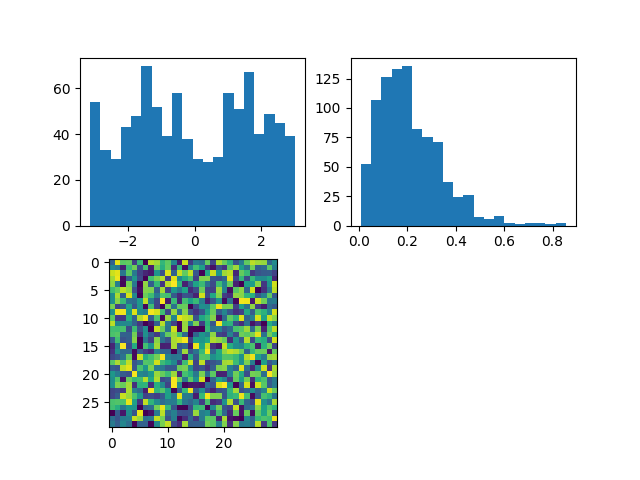

<IPython.core.display.Javascript object>


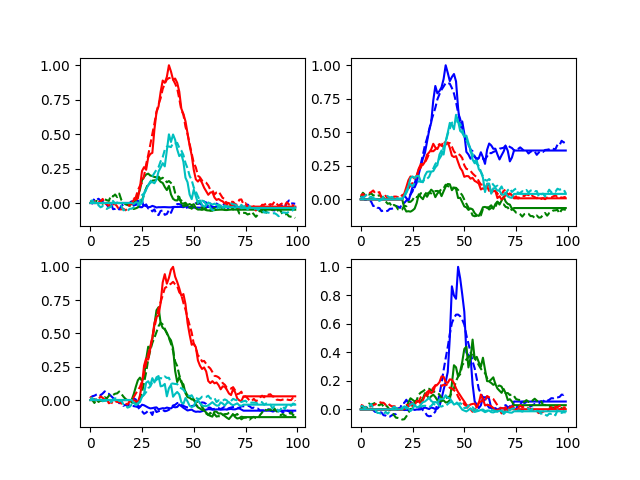

<IPython.core.display.Javascript object>


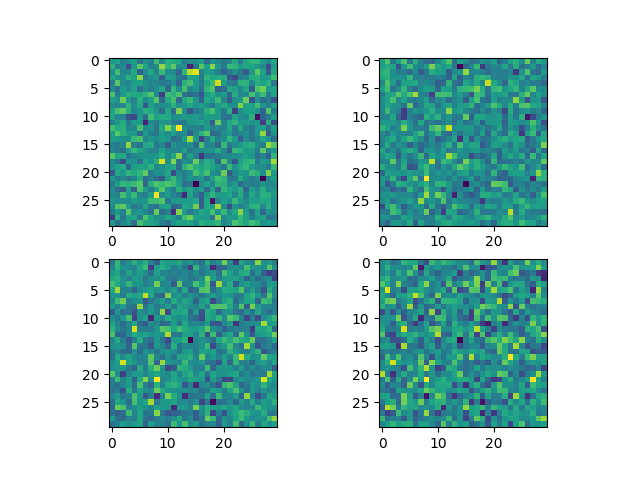

(4, 1, 30, 30)


<IPython.core.display.Javascript object>


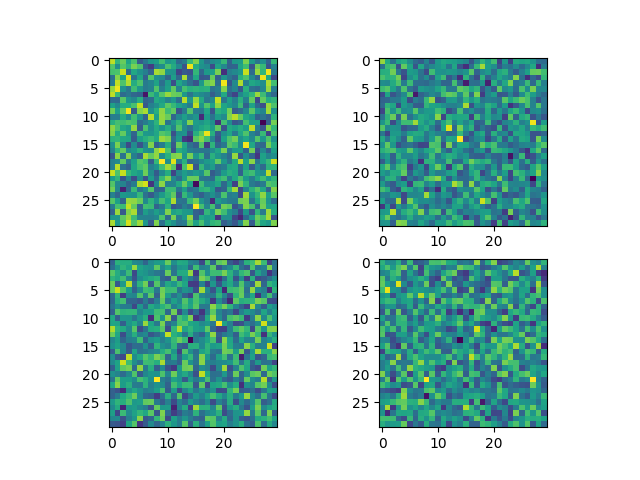

(4, 1, 30, 30)


<IPython.core.display.Javascript object>


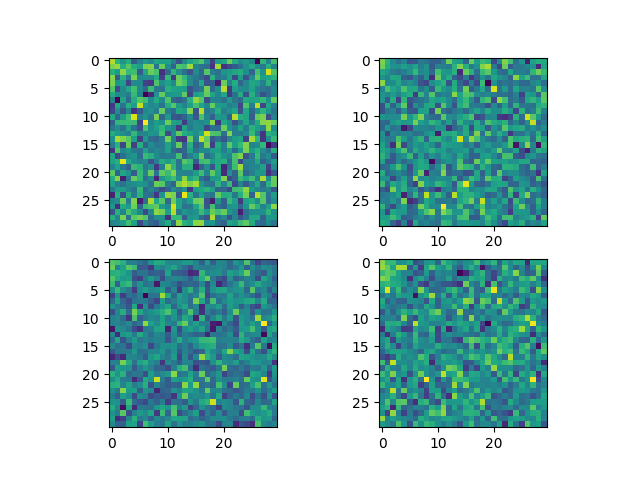

(4, 1, 30, 30)


In [6]:
color_list=['b','g','r','c','m','y','k','tab:purple']
        
go_cue_offset = [10,30]
activations = activation_model.predict(x_test)
rnn_activations = activations[1]
y_pred = activations[-1]
pd_data,depth_data = get_pds(rnn_activations,go_cue_offset[0]+go_cue_idx,go_cue_offset[1]+go_cue_idx)

plt.figure()
plt.subplot(2,2,1)
plt.hist(pd_data,20);
plt.subplot(2,2,2)
plt.hist(depth_data,20);
plt.subplot(2,2,3)

pd_grid = np.zeros(args.latent_shape)
pos_lis = cell.pos.astype("int")
for i in range(pd_data.shape[0]):
    pd_grid[pos_lis[i,0],pos_lis[i,1]] = pd_data[i]
plt.imshow(pd_grid)

if(predict_emg==1):
    out_idx = [12,14,16,18]
else:
    out_idx = [0,1]
    
plt.figure()
for i_out in range(len(out_idx)):
    plt.subplot(2,2,i_out+1)
    for tgt_dir_idx in range(y_test.shape[0]):
        plt.plot(np.transpose(y_pred[tgt_dir_idx,:,out_idx[i_out]]),'--',color=color_list[tgt_dir_idx]) 
        plt.plot(np.transpose(y_test[tgt_dir_idx,:,out_idx[i_out]]),'-',color=color_list[tgt_dir_idx])
        
        
rnn_activation_grid = make_activation_grid(rnn_activations,cell,args)
idx_plot = [go_cue_idx,go_cue_idx+10]
plot_activation_grids(rnn_activation_grid,idx_plot)

idx_plot = [go_cue_idx+15,go_cue_idx+20]
plot_activation_grids(rnn_activation_grid,idx_plot)
    
idx_plot = [go_cue_idx+30,go_cue_idx+35]
plot_activation_grids(rnn_activation_grid,idx_plot)

<IPython.core.display.Javascript object>


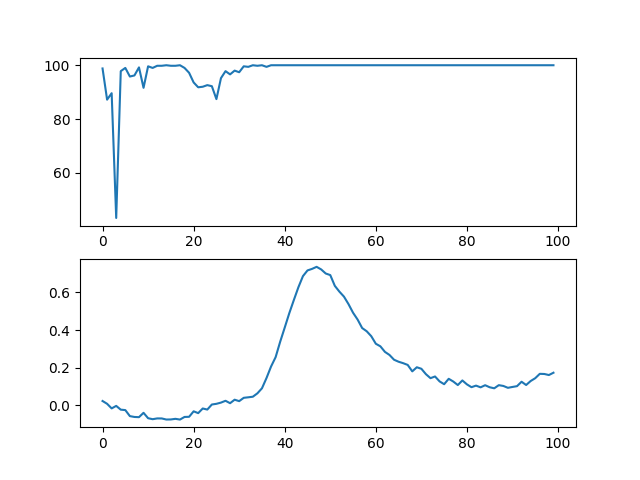

In [7]:
# compare activation map vs shuffled maps to see if there is an organization of neurons
num_shuffles = 500
        
activations = activation_model.predict(x_test)
rnn_activations = activations[1]    
rnn_activations.shape
act_loss, shuffled_loss, act_loss_perc = evaluate_topography(rnn_activations)

plt.figure()
plt.subplot(2,1,1)
plt.plot(100-act_loss_perc) # bigger = more organization
plt.subplot(2,1,2)
plt.plot(y_pred[0,:,0])

<IPython.core.display.Javascript object>


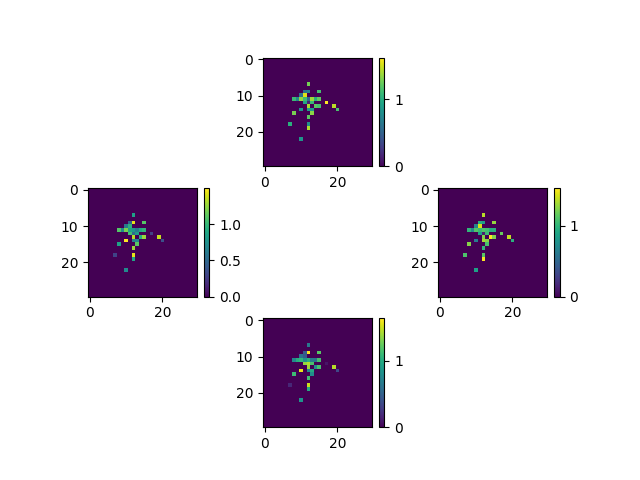

<IPython.core.display.Javascript object>


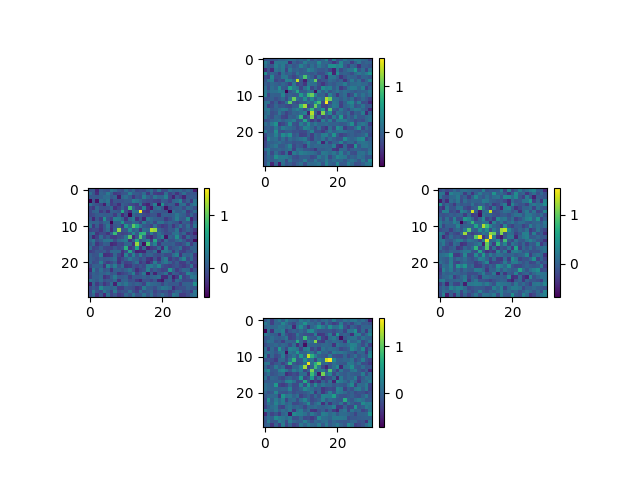

<IPython.core.display.Javascript object>


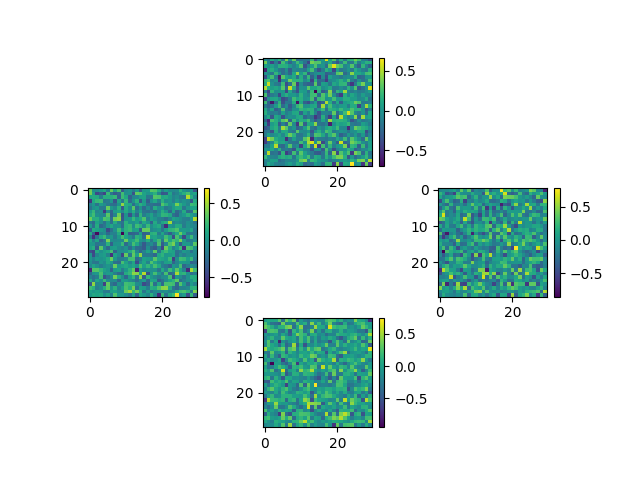

<IPython.core.display.Javascript object>


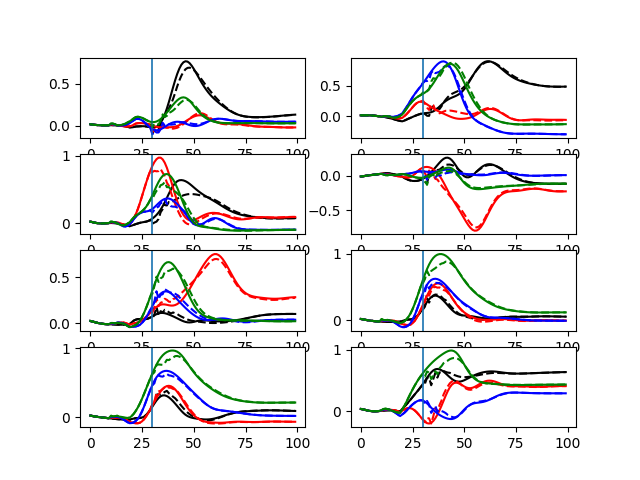

[13. 13.]
-1.0658707509678296


<IPython.core.display.Javascript object>


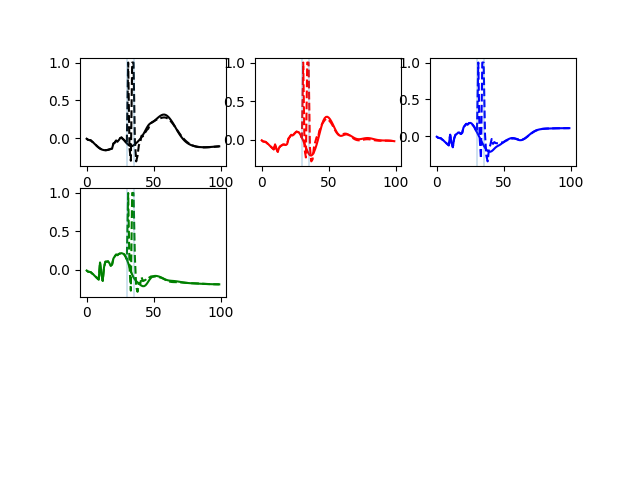

In [8]:
# example stim experiment

stim_params = StimParams()
args.noise_val = 0.0
stim_params.stim_pos = np.array([12,12])
stim_params.stim_dist_tau = 2
stim_params.stim_time = [go_cue_idx+10,go_cue_idx+15]

rnn_activations_stim,rnn_activations_no_stim,rnn_activation_grid_stim,rnn_activation_grid_no_stim,y_pred_stim,y_pred_no_stim = run_example_stim_exp()

rnn_activation_grid_diff = rnn_activation_grid_stim - rnn_activation_grid_no_stim

# plot activation difference
plt.figure()
subplot_idx = [6,2,4,8]
for i in range(len(subplot_idx)):
    plt.subplot(3,3,subplot_idx[i])
    plt.imshow(rnn_activation_grid_diff[i,stim_params.stim_time[0],:,:])
    plt.colorbar()
 

plt.figure()
subplot_idx = [6,2,4,8]
for i in range(len(subplot_idx)):
    plt.subplot(3,3,subplot_idx[i])
    plt.imshow(rnn_activation_grid_diff[i,stim_params.stim_time[0]+2,:,:])
    plt.colorbar()
    
plt.figure()
subplot_idx = [6,2,4,8]
for i in range(len(subplot_idx)):
    plt.subplot(3,3,subplot_idx[i])
    plt.imshow(rnn_activation_grid_diff[i,stim_params.stim_time[1]+1,:,:])
    plt.colorbar()

# plot prediction in both cases
plt.figure()
out_idx = [0,1,2,3,4,5,6,7]
color_list = ['k','r','b','g']
counter = 0
for musc_idx in out_idx:
    plt.subplot(4,2,counter+1)
    for tgt_dir_idx in range(y_pred_no_stim.shape[0]):
        plt.plot(y_pred_no_stim[tgt_dir_idx,:,musc_idx],color=color_list[tgt_dir_idx])
        plt.plot(y_pred_stim[tgt_dir_idx,:,musc_idx],linestyle='--',color=color_list[tgt_dir_idx])
        plt.axvline(stim_params.stim_time[0],linewidth=0.3)
        plt.axvline(stim_params.stim_time[0],linewidth=0.3)
        
    counter = counter + 1
    
# example neuron -- pick based on stim electrode location
rec_neuron = get_recorded_neuron(stim_params.stim_pos,cell.pos)

print(cell.pos[rec_neuron,:])
print(pd_data[rec_neuron])

plt.figure()
unit=rec_neuron
for tgt_idx in range(rnn_activations_no_stim.shape[0]):
    plt.subplot(3,3,tgt_idx+1)
    plt.plot(np.transpose(rnn_activations_no_stim[tgt_idx,:,unit]),color=color_list[tgt_idx]);
    plt.plot(np.transpose(rnn_activations_stim[tgt_idx,:,unit]),'--',color=color_list[tgt_idx]);
    plt.axvline(stim_params.stim_time[0],linewidth=0.3)
    plt.axvline(stim_params.stim_time[1],linewidth=0.3)  

0.0
0.04
0.08
0.12
0.16
0.2
0.24
0.28
0.32
0.36
0.4
0.44
0.48
0.52
0.56
0.6
0.64
0.68
0.72
0.76
0.8
0.84
0.88
0.92
0.96
done


<IPython.core.display.Javascript object>


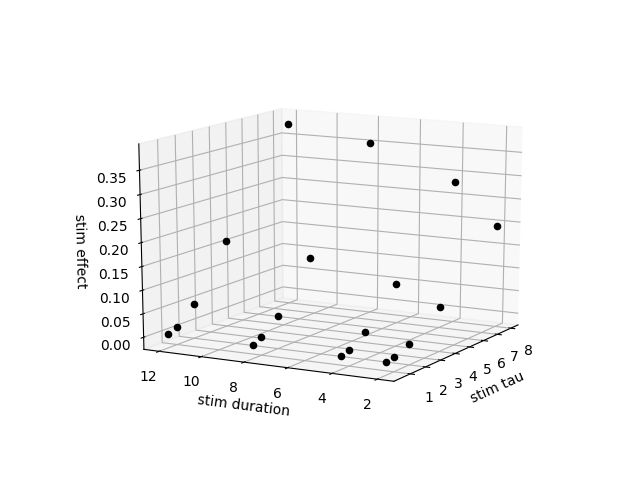

<IPython.core.display.Javascript object>


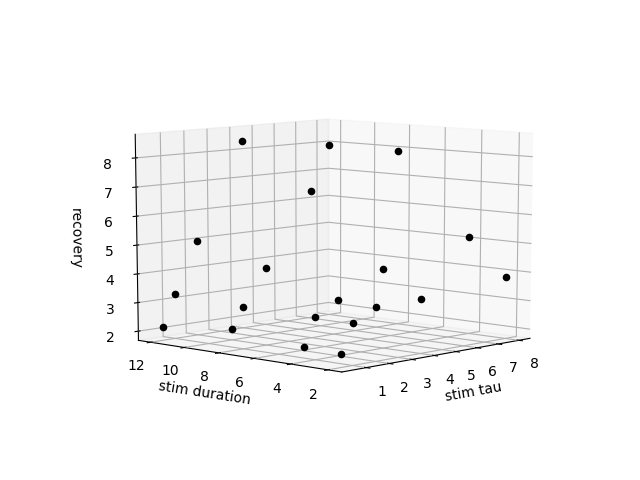

<IPython.core.display.Javascript object>


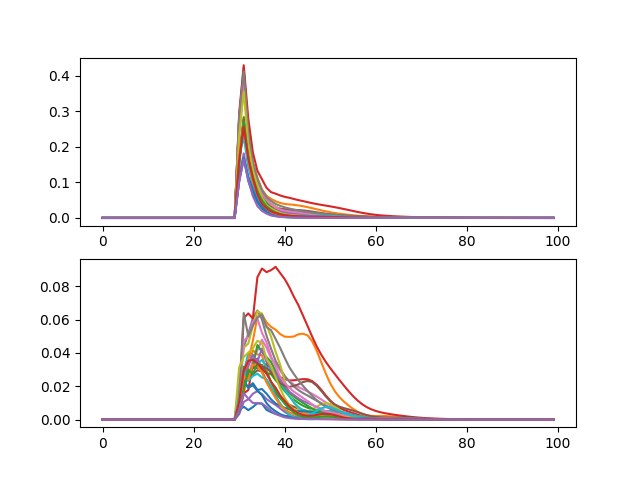

In [9]:
# neural and emg recovery across stim amps, locations, and durations

stim_params = StimParams()
# get stim conditions
x = np.linspace(0, args.latent_shape[0], 5, dtype=np.float32)
y = np.linspace(0, args.latent_shape[1], 5, dtype=np.float32)
xv, yv = np.meshgrid(x, y)
xv = np.reshape(xv, (xv.size, 1))
yv = np.reshape(yv, (yv.size, 1))
stim_pos_test = np.hstack((xv, yv))
stim_dist_tau_test = [0.5,1,2,4,8]
stim_duration_test = [2,4,8,12]

emg_msd, rnn_msd, emg_recov, emg_stim_effect, rnn_recov, rnn_stim_effect=run_stim_exp()

# average over stim positions
emg_recov_mean = np.mean(np.mean(emg_recov,axis=3),axis=0)
emg_stim_effect_mean = np.mean(np.mean(emg_stim_effect,axis=3),axis=0)
rnn_recov_mean = np.mean(np.mean(rnn_recov,axis=3),axis=0)
rnn_stim_effect_mean = np.mean(np.mean(rnn_stim_effect,axis=3),axis=0)

# plot effect of amplitude and stim duration
plt.figure()
ax = plt.axes(projection='3d')
for i_tau in range(len(stim_dist_tau_test)):
    for i_dur in range(len(stim_duration_test)):
        ax.scatter3D(stim_dist_tau_test[i_tau],stim_duration_test[i_dur],rnn_stim_effect_mean[i_tau,i_dur],'.',color='k');
        
ax.set_xlabel("stim tau")
ax.set_ylabel("stim duration")
ax.set_zlabel("stim effect")

# plot recovery with different amplitudes and stim durations
plt.figure()
ax = plt.axes(projection='3d')
for i_tau in range(len(stim_dist_tau_test)):
    for i_dur in range(len(stim_duration_test)):
        ax.scatter3D(stim_dist_tau_test[i_tau],stim_duration_test[i_dur],rnn_recov_mean[i_tau,i_dur],'.',color='k');
        
ax.set_xlabel("stim tau")
ax.set_ylabel("stim duration")
ax.set_zlabel("recovery")

# plot example MSD for rnn and emg
plt.figure()
plt.subplot(2,1,1)
plt.plot(np.transpose(rnn_msd[:,-1,0,2,:]));
plt.subplot(2,1,2)
plt.plot(np.transpose(emg_msd[:,-1,0,2,:]));

In [ ]:
# dynamical analysis (PCA? and such on activations in RNN layer)
# activations is tgt_dir x time x neuron
# truncate activations from go cue to end
stim_params = StimParams()
args.noise_val = 0.0
stim_params.stim_pos = np.array([10,10])
stim_params.stim_dist_tau = 5
stim_params.stim_time = [go_cue_idx+10,go_cue_idx+15]

rnn_activations_stim,rnn_activations_no_stim,rnn_activation_grid_stim,rnn_activation_grid_no_stim,y_pred_stim,y_pred_no_stim = run_example_stim_exp()

rnn_no_stim_trunc = rnn_activations_no_stim[:,:,:]
rnn_stim_trunc = rnn_activations_stim[:,:,:]

rnn_activations_no_stim_flat = rnn_no_stim_trunc.reshape(-1,rnn_activations_no_stim.shape[-1])
rnn_activations_stim_flat = rnn_stim_trunc.reshape(-1,rnn_activations_stim.shape[-1])

pca = PCA(n_components=10)
pca.fit(rnn_activations_no_stim_flat)

rnn_pca_no_stim = pca.transform(rnn_activations_no_stim_flat)
rnn_pca_stim = pca.transform(rnn_activations_stim_flat)
rnn_pca_no_stim = rnn_pca_no_stim.reshape(len(degs),int(rnn_pca_no_stim.shape[0]/len(degs)),rnn_pca_no_stim.shape[1])
rnn_pca_stim = rnn_pca_stim.reshape(len(degs),int(rnn_pca_stim.shape[0]/len(degs)),rnn_pca_stim.shape[1])

dims = [0,1]
plt.figure()
for tgt_idx in range(rnn_pca_no_stim.shape[0]):
    plot_pca_traces(rnn_pca_no_stim,tgt_idx,dims)
    plot_pca_traces(rnn_pca_stim,tgt_idx,dims,is_stim=True)
    
plt.figure()
for tgt_idx in range(rnn_pca_no_stim.shape[0]):
    plt.subplot(3,3,tgt_idx+1)
    plot_pca_traces(rnn_pca_no_stim,tgt_idx,dims)
    plot_pca_traces(rnn_pca_stim,tgt_idx,dims,is_stim=True)
    
    


In [ ]:
# dpca
# X = multi dimensional array. [n,t,s,d] where n is neurons, t is time, s is stimulus, d is decision
# labels = optional; list of characters to describe parameter axes ('tsd')
# n_components = Dictionary or integer; if integer use the same number of components in each marginalization,
    #otherwise every (key,value) pair refers to the number of components (value) in a marginalization (key).
stim_params = StimParams()
args.noise_val = 0.0
stim_params.stim_pos = np.array([0,0])
stim_params.stim_dist_tau = 1
stim_params.stim_time = [go_cue_idx+10,go_cue_idx+15]

rnn_activations_stim,rnn_activations_no_stim,\
    rnn_activation_grid_stim,rnn_activation_grid_no_stim,\
    y_pred_stim,y_pred_no_stim = run_example_stim_exp()
        
X_no_stim = np.transpose(rnn_activations_no_stim,(2,1,0))
X_stim = np.transpose(rnn_activations_stim,(2,1,0))

labels = 'ts'
dpca = dPCA.dPCA(labels)
dpca.protect = ['t']
Z_no_stim = dpca.fit_transform(X_no_stim)
Z_stim = dpca.transform(X_stim)

for i_dim in range(3):
    plt.figure()
    plot_dpca_traces(Z_no_stim,0,'t',i_dim)
    plot_dpca_traces(Z_stim,1,'t',i_dim)
     
dims = [0,1]
plt.figure()
for i_tgt in range(Z_stim['s'].shape[-1]):
    plt.plot(Z_no_stim['s'][dims[0],:,i_tgt],Z_no_stim['s'][dims[1],:,i_tgt])
    #plt.plot(Z_stim['s'][dims[0],:,i_tgt],Z_stim['s'][dims[1],:,i_tgt])

In [ ]:
# Potent and Null space analysis
# get a mapping from neuron activation to muscle activation
explained_var_thresh = 0.75

%run ./RNN_analysis_functions.ipynb

activations = activation_model.predict(x_test)
neural_act = activations[1] 
muscle_act = activations[-1]

neural_act_flat = flatten_activation_mat(neural_act)
muscle_act_flat = flatten_activation_mat(muscle_act)

# reduce dimensions -- match explained variance across muscles and neurons
neural_pca = PCA()
muscle_pca = PCA()
neural_pca.fit(neural_act_flat)
muscle_pca.fit(muscle_act_flat)

n_neural_comp = np.argwhere(np.cumsum(neural_pca.explained_variance_ratio_) >= explained_var_thresh)[0][0]
n_muscle_comp = np.argwhere(np.cumsum(muscle_pca.explained_variance_ratio_) >= explained_var_thresh)[0][0]

neural_pca = PCA(n_components=n_neural_comp)
muscle_pca = PCA(n_components=n_muscle_comp)
neural_act_low_dim = unflatten_activation_mat(neural_pca.fit_transform(neural_act_flat),neural_act)
muscle_act_low_dim = unflatten_activation_mat(muscle_pca.fit_transform(muscle_act_flat),muscle_act)

# project
null_space, potent_space = get_null_potent_space(neural_act_low_dim, muscle_act_low_dim) # neural dims, muscle dims
neural_null_proj = project_into_space(neural_act_low_dim, null_space)
neural_pot_proj = project_into_space(neural_act_low_dim, potent_space)

# stimulate and project activations into potent and null space -- do this for different amplitudes and stim locations
stim_params = StimParams()
args.noise_val = 0.0
stim_params.stim_time = [go_cue_idx+10,go_cue_idx+15]
amps_test = np.array([0.5,1,2,5,10])
# get locs test
x = np.linspace(0, args.latent_shape[0], 5, dtype=np.float32)
y = np.linspace(0, args.latent_shape[1], 5, dtype=np.float32)
xv, yv = np.meshgrid(x, y)
xv = np.reshape(xv, (xv.size, 1))
yv = np.reshape(yv, (yv.size, 1))
stim_pos_test = np.hstack((xv, yv))

null_dist = np.zeros((amps_test.shape[0],stim_pos_test.shape[0],neural_act.shape[1]))
pot_dist = np.zeros_like(null_dist)

neural_stim_null_proj_all = np.zeros((amps_test.shape[0],stim_pos_test.shape[0],\
                                      neural_act.shape[0],neural_act.shape[1],\
                                      n_neural_comp-n_muscle_comp))
neural_stim_pot_proj_all = np.zeros((amps_test.shape[0],stim_pos_test.shape[0],\
                                     neural_act.shape[0],neural_act.shape[1],\
                                      n_muscle_comp))

for i_amp in range(amps_test.shape[0]):
    for i_loc in range(stim_pos_test.shape[0]):
        stim_params.stim_pos = stim_pos_test[i_loc,:]
        stim_params.stim_dist_tau = amps_test[i_amp]


        neural_act_stim,neural_act_no_stim,\
            neural_act_grid_stim,neural_act_grid_no_stim,\
            musc_pred_stim,musc_pred_no_stim = run_example_stim_exp()

        # lower dimensionality then project stim data into spaces
        neural_act_stim_flat = flatten_activation_mat(neural_act_stim)
        neural_act_stim_low_d =  unflatten_activation_mat(neural_pca.transform(neural_act_stim_flat),neural_act_stim)

        neural_stim_null_proj = project_into_space(neural_act_stim_low_d,null_space)
        neural_stim_pot_proj = project_into_space(neural_act_stim_low_d,potent_space)

        # compute distance moved from normal trajectory during stim condition in null and potent space across time and store
        null_dist[i_amp,i_loc,:] = np.sum(np.sum(np.square(neural_stim_null_proj - neural_null_proj),axis=2),axis=0)
        pot_dist[i_amp,i_loc,:] = np.sum(np.sum(np.square(neural_stim_pot_proj - neural_pot_proj),axis=2),axis=0)
        
        # store all proj data
        neural_stim_null_proj_all[i_amp,i_loc,:,:,:] = neural_stim_null_proj
        neural_stim_pot_proj_all[i_amp,i_loc,:,:,:] = neural_stim_pot_proj

In [ ]:
# analyze distance data -- time course (potent recovers slower than null?), 
    # magnitude post stim relative to pre stim (hump after end of stim implies planning?)

# plot dists for example site and amp
plt.figure() 
plt.plot(np.transpose(null_dist[4,12,:]),color='k');
plt.plot(np.transpose(pot_dist[4,12,:]),color='r');
plt.axvline(stim_params.stim_time[0],linewidth=0.5)
plt.axvline(stim_params.stim_time[1],linewidth=0.5)

# compare distances between null and pot across amps and sites
summed_null_dist = np.sum(null_dist,axis=2)
summed_pot_dist = np.sum(pot_dist,axis=2)
plot_space_dist(summed_null_dist,summed_pot_dist)
    
summed_null_dist = np.sum(null_dist[:,:,stim_params.stim_time[0]:stim_params.stim_time[1]],axis=2)
summed_pot_dist = np.sum(pot_dist[:,:,stim_params.stim_time[0]:stim_params.stim_time[1]],axis=2)
plot_space_dist(summed_null_dist,summed_pot_dist) 

summed_null_dist = np.sum(null_dist[:,:,stim_params.stim_time[1]+1:stim_params.stim_time[1]+5],axis=2)
summed_pot_dist = np.sum(pot_dist[:,:,stim_params.stim_time[1]+1:stim_params.stim_time[1]+5],axis=2)
plot_space_dist(summed_null_dist,summed_pot_dist) 

In [ ]:
# plot proj onto null space and proj onto potent space (on the same axis?)
plt.figure()
dim = 0;
tgt = 2;
plt.plot(neural_stim_null_proj[tgt,:,dim],neural_stim_pot_proj[tgt,:,dim])
plt.plot(neural_stim_null_proj[tgt,stim_params.stim_time[0]:stim_params.stim_time[1],dim],\
         neural_stim_pot_proj[tgt,stim_params.stim_time[0]:stim_params.stim_time[1],dim])
plt.plot(neural_stim_null_proj[tgt,0,dim],neural_stim_pot_proj[tgt,0,dim],markersize=20,marker='.')
plt.plot(neural_stim_null_proj[tgt,go_cue_idx,dim],neural_stim_pot_proj[tgt,go_cue_idx,dim],markersize=20,marker='.')
plt.plot(neural_stim_null_proj[tgt,50,dim],neural_stim_pot_proj[tgt,50,dim],markersize=20,marker='.')

In [ ]:
tgt = 2
amp = 3
loc = 10

plt.figure()
plt.subplot(2,1,1)
plt.plot(neural_pot_proj[tgt,:,:])
plt.gca().set_prop_cycle(None)
plt.plot(neural_stim_pot_proj_all[amp,loc,tgt,:,:],linestyle='--')
plt.axvline(hold_idx,linewidth=0.5)
plt.axvline(go_cue_idx,linewidth=0.5)
plt.axvline(stim_params.stim_time[0],linewidth=0.5)
plt.axvline(stim_params.stim_time[1],linewidth=0.5)

plt.subplot(2,1,2)
plt.plot(neural_null_proj[tgt,:,:])
plt.gca().set_prop_cycle(None)
plt.plot(neural_stim_null_proj_all[amp,loc,tgt,:,:],linestyle='--')
plt.axvline(hold_idx,linewidth=0.5)
plt.axvline(go_cue_idx,linewidth=0.5)
plt.axvline(stim_params.stim_time[0],linewidth=0.5)
plt.axvline(stim_params.stim_time[1],linewidth=0.5)